## Прогнозирование количества заказов такси

### 1. Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings as warn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

Прочитаем файл и сохраним его в переменной *taxi*, проиндексировав датафрейм по дате и времени.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим расположены ли объекты в хронологическом порядке.

In [3]:
taxi.index.is_monotonic

True

Посмотрим таблицу и общую информацию о ней.

In [4]:
display(taxi.head(6))
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Датафрейм содержит 26496 строк и столбец с количеством заказов такси в течение 10-минутных отрезков времени. Выполним ресемплирование данных по 1 часу.

In [5]:
taxi = taxi.resample('1H').sum()
display(taxi.head(6))
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### 2. Анализ данных

Исследуем как менялось число заказов такси в течение всего доступного периода времени. Для этого построим графики суточного числа заказов, а также скользящее среднее и скользящее стандартное отклонение с окном, равным неделе.

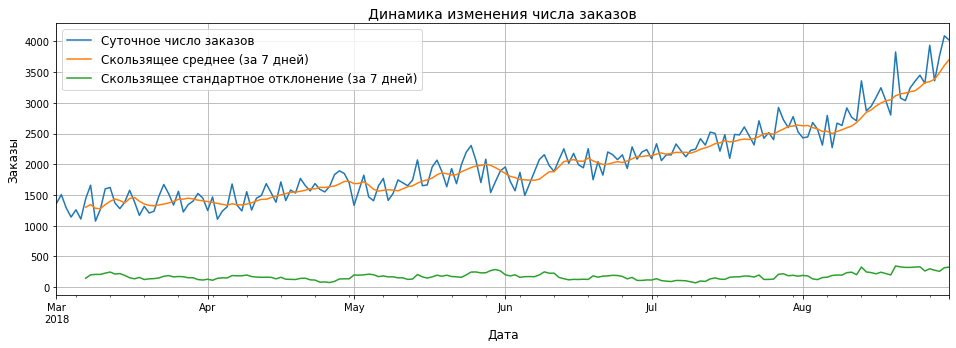

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
resample_by_day = taxi.resample('1D').sum()
resample_by_day.plot(ax=ax)
resample_by_day.rolling(7).mean().plot(ax=ax)
resample_by_day.rolling(7).std().plot(ax=ax)
ax.set_title('Динамика изменения числа заказов', fontsize=14)
ax.legend(['Суточное число заказов',
           'Скользящее среднее (за 7 дней)',
           'Скользящее стандартное отклонение (за 7 дней)'], fontsize=12)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Заказы', fontsize=12)
ax.grid(True)

По графикам видно, что в течение всего доступного периода времени число заказов растёт. Это говорит об увеличении популярности компании и низком влиянии сезонного фактора.

Исследуем как меняется количество заказов в зависимости от дня недели, построив график сезонности.

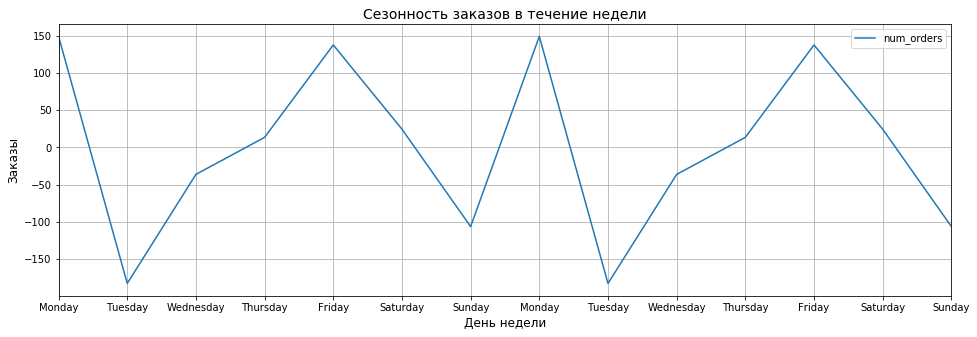

In [7]:
decomposed = seasonal_decompose(resample_by_day)
date_range = pd.date_range(start='2018-08-13', end='2018-08-26', freq='1D')

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
decomposed.seasonal['2018-08-13':'2018-08-26'].plot(ax=ax, grid=True);
ax.set_title('Сезонность заказов в течение недели', fontsize=14)
ax.set_xlabel('День недели', fontsize=12)
ax.set_ylabel('Заказы', fontsize=12)
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%A'));

Наибольшее число заказов наблюдается в понедельник и пятницу, наименьшее — во вторник и воскресенье.

Аналогичным образом исследуем изменение количества заказов в течение дня.

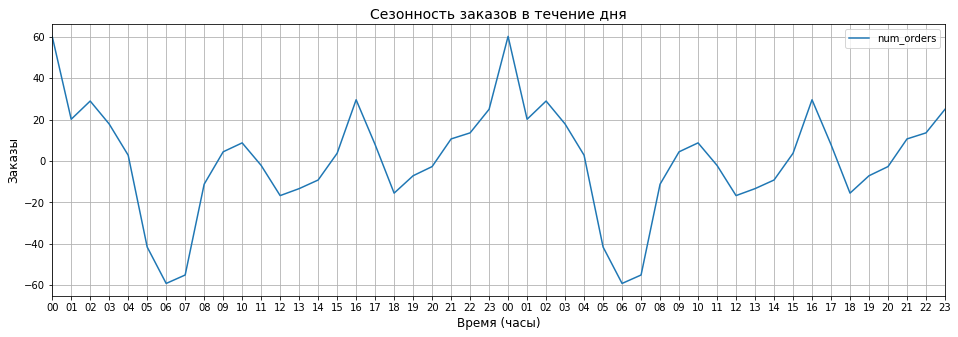

In [8]:
decomposed = seasonal_decompose(taxi)
date_range = pd.date_range(start='2018-08-29', end='2018-08-30 23:00:00', freq='1H')

fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
decomposed.seasonal['2018-08-29':'2018-08-30 23:00:00'].plot(ax=ax, grid=True);
ax.set_title('Сезонность заказов в течение дня', fontsize=14)
ax.set_xlabel('Время (часы)', fontsize=12)
ax.set_ylabel('Заказы', fontsize=12)
ax.set_xticks(date_range)
ax.set_xticklabels(date_range.strftime('%H'));

Чаще всего люди заказывают такси в аэропортах в районе полуночи, реже всего — рано утром (с 5 до 7 часов).

### Вывод

Компания имеет растущий тренд в течение всего рассматриваемого периода времени, при этом присутствуют циклические закономерности, которые обуславливают изменение числа заказов такси в зависимости от дня недели и времени суток.

### 3. Обучение моделей

Так как день недели и время суток влияет на количество заказов, создадим соответствующие календарные признаки *day* и *hour*. Также создадим признаки с отстающими значениями *lag_1*...*lag_4*, которые покажут рост или спад функции, и скользящее среднее с 24-часовым окном, которое задаст общий тренд временного ряда.

In [9]:
taxi['day'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        taxi['lag_' + str(lag)] = taxi['num_orders'].shift(lag)
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 4, 24)
taxi.dropna(inplace=True)

Разделим датасет на обучающую и тестовую выборки. Выделим целевой признак.

In [10]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print('{:>20} {:>8}'.format('features', 'target'))
print('Обучающая: {:>10} {:>8}'.format(str(features_train.shape), str(target_train.shape)))
print('Тестовая: {:>10} {:>8}'.format(str(features_test.shape), str(target_test.shape)))

            features   target
Обучающая:  (3952, 7)  (3952,)
Тестовая:   (440, 7)   (440,)


Создадим RMSE-scorer для дальнейшего использования в качестве метрики.

In [11]:
def rmse(y_true, y_predict):
    return (((y_true - y_predict) ** 2).mean()) ** 0.5

rmse_score = make_scorer(rmse, greater_is_better=False) 

Обучим модель линейной регрессии с кросс-валидацией.

In [12]:
model = LinearRegression()
lr_cv = cross_validate(model, features_train, target_train, cv=4, n_jobs=-1, scoring=rmse_score)
print('Линейная регрессия')
print('RMSE = {:.2f}'.format(abs(lr_cv['test_score'].mean())))

Линейная регрессия
RMSE = 30.70


С помощью функции *GridSearchCV* обучим по сетке с различными гиперпараметрами модели градиентного бустинга, основанные на библиотеках *XGBoost*, *LightGBM* и *CatBoost*. Определим гиперпараметры с наилучшими метриками RMSE.

In [13]:
warn.filterwarnings('ignore')

model = XGBRegressor(n_estimators=200, verbosity=0)
parameters = {'learning_rate': np.arange(0.05, 0.26, 0.05),
              'max_depth': [2, 3, 4]}
xgb_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring=rmse_score)
xgb_grid.fit(features_train, target_train)

warn.filterwarnings('default')

print('XGBoost')
print('Лучшие гиперпараметры: ', xgb_grid.best_params_)
print('RMSE = {:.2f}'.format(abs(xgb_grid.best_score_)))

XGBoost
Лучшие гиперпараметры:  {'learning_rate': 0.1, 'max_depth': 3}
RMSE = 24.66


In [14]:
model = LGBMRegressor(n_estimators=200)
parameters = {'learning_rate': np.arange(0.05, 0.26, 0.05),
              'num_leaves': [3, 7, 15]}
lgbm_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring=rmse_score)
lgbm_grid.fit(features_train, target_train)

print('LightGBM')
print('Лучшие гиперпараметры: ', lgbm_grid.best_params_)
print('RMSE = {:.2f}'.format(abs(lgbm_grid.best_score_)))

LightGBM
Лучшие гиперпараметры:  {'learning_rate': 0.1, 'num_leaves': 7}
RMSE = 24.46


In [15]:
model = CatBoostRegressor(iterations=200, verbose=False)
parameters = {'learning_rate': np.arange(0.05, 0.26, 0.05),
              'depth': [2, 3, 4]}
cb_grid = GridSearchCV(model, parameters, cv=4, n_jobs=-1, scoring=rmse_score)
cb_grid.fit(features_train, target_train)

print('CatBoost')
print('Лучшие гиперпараметры: ', cb_grid.best_params_)
print('RMSE = {:.2f}'.format(abs(cb_grid.best_score_)))

CatBoost
Лучшие гиперпараметры:  {'depth': 4, 'learning_rate': 0.1}
RMSE = 24.65


#### Вывод

Из всех рассмотренных моделей линейная регрессия показала худшее значение метрики RMSE (30.70). Результаты моделей из семейства градиентного бустинга близки друг к другу, при этом модель, основанная на библиотеке *LightGBM*, имеет наилучшее качество (24.46).

### 4. Тестирование модели

Исследуем полученные результаты более подробно.

In [16]:
grids = {'XGBoost': xgb_grid,
         'LightGBM': lgbm_grid,
         'CatBoost': cb_grid}

results = grids.copy()
for i in grids.keys():
    results[i] = abs(round(pd.DataFrame(grids[i].cv_results_)
                           .iloc[:, [4, 5, 0, 2, 11]]
                           .sort_values('mean_test_score', ascending=False)
                           .head(5), 2))
    print(i)
    display(results[i])

XGBoost


,param_learning_rate,param_max_depth,mean_fit_time,mean_score_time,mean_test_score
4,0.1,3,0.38,0.01,24.66
2,0.05,4,0.45,0.01,24.79
6,0.15,2,0.4,0.01,24.92
1,0.05,3,0.36,0.01,24.97
5,0.1,4,0.56,0.01,24.98


LightGBM


,param_learning_rate,param_num_leaves,mean_fit_time,mean_score_time,mean_test_score
4,0.1,7,0.1,0.01,24.46
2,0.05,15,0.16,0.02,24.54
5,0.1,15,0.15,0.02,24.55
7,0.15,7,0.1,0.01,24.64
9,0.2,3,0.06,0.01,24.74


CatBoost


,param_depth,param_learning_rate,mean_fit_time,mean_score_time,mean_test_score
11,4,0.1,5.55,0.01,24.65
13,4,0.2,3.18,0.01,24.7
8,3,0.2,2.89,0.01,24.84
6,3,0.1,2.94,0,24.91
7,3,0.15,2.92,0.01,24.91


Из полученных таблиц видно, что качество моделей *LightGBM* немного выше, а время обучения в разы ниже, чем у алгоритмов *XGBoost* и *CatBoost*. Исходя из этого, в качестве финальной модели выберем модель градиентного бустинга, основанную на библиотеке LightGBM, с количеством листьев, равным 7, и learning rate, равным 0.1, RMSE которой на кросс-валидации составил 24.46. Обучим её на всей тренировочной выборке и проверим качество предсказаний на тестовой выборке.

In [17]:
model = LGBMRegressor(n_estimators=200, learning_rate=0.1, num_leaves=7)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('RMSE = {:.2f}'.format(rmse(target_test, predictions)))

RMSE = 42.44


Таким образом, итоговая метрика RMSE на тестовой выборке составила 42.44, что соответствует целевому показателю.

Сравним полученные предсказания с целевым признаком тестовой выборки, построив их графики за весь период прогноза, а также в его начале и конце с увеличенным масштабом.

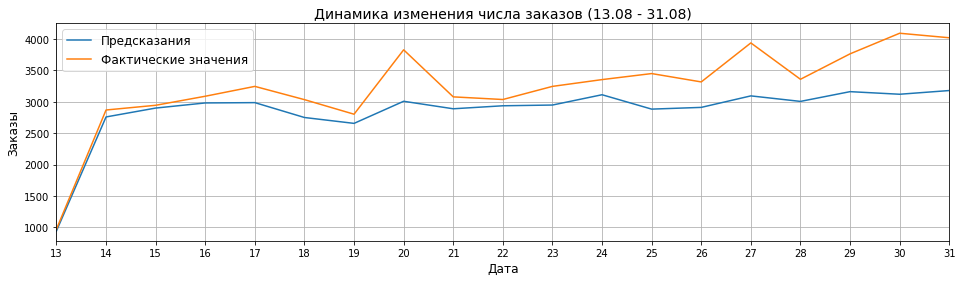

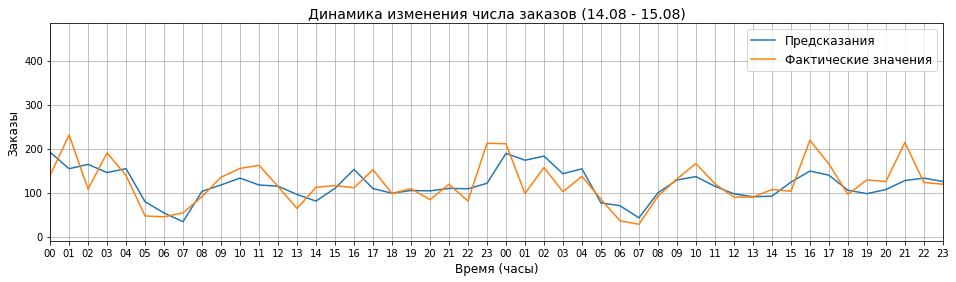

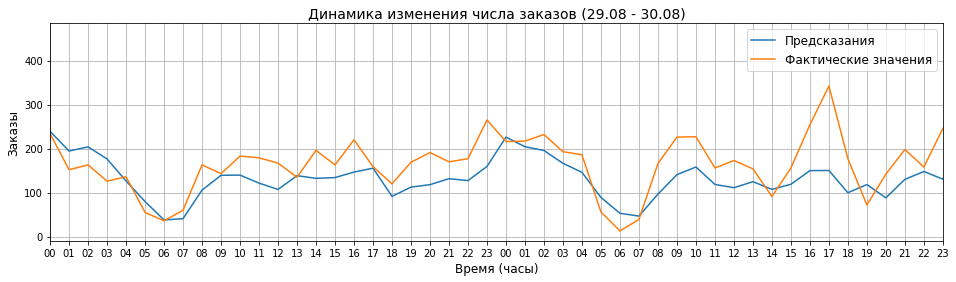

In [18]:
def plots(freq, start, finish):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 4)
    pd.DataFrame(predictions, index=target_test.index).resample(freq).sum().plot(ax=ax)
    target_test.resample(freq).sum().plot(ax=ax)
    ax.set_title('Динамика изменения числа заказов ({} - {})'
                 .format(pd.to_datetime(start).strftime('%d.%m'), pd.to_datetime(finish).strftime('%d.%m')), fontsize=14)
    ax.legend(['Предсказания',
               'Фактические значения'], fontsize=12)
    ax.set_xlabel('Время (часы)', fontsize=12)
    ax.set_ylabel('Заказы', fontsize=12)
    ax.set_xlim(start, finish)
    ax.grid(True)
    date_range = pd.date_range(start=start, end=finish, freq=freq)
    ax.set_xticks(date_range)
    ax.set_xticklabels(date_range.strftime('%' + freq[1]))
    if freq == '1D':
        ax.set_xlabel('Дата', fontsize=12)
        ax.set_xticklabels(date_range.strftime('%' + freq[1].lower()))

plots('1D', '2018-08-13', '2018-08-31 23:00:00')
plots('1H', '2018-08-14', '2018-08-15 23:00:00')
plots('1H', '2018-08-29', '2018-08-30 23:00:00')

По полученным графикам видно, что изначально высокая точность прогнозирования постепенно снижалась и накапливалась всё большая ошибка, так как фактический тренд рос сильнее предсказанного. Это говорит о том, что модель будет демонстрировать наилучшее качество при коротком горизонте прогнозирования.

Почасовые графики предсказаний являются более сглаженными, чем графики фактических значений. Это объясняется тем, что модель не может в достаточной степени точно предсказывать выбросы, поскольку основана только на исторических данных и не учитывает множество различных факторов, которые являются причинами колебаний. Также можно отметить, что модель иногда немного завышает оценку числа заказов в ночное время.

### 5. Вывод

В ходе выполнения проекта выполнено ресемплирование данных, исследованы тренд и сезонность, созданы признаки, обучены модели линейной регрессии и градиентного бустинга на основе библиотек *XGBoost*, *LightGBM* и *CatBoost* c различными гиперпараметрами. Установлено, что модель линейной регрессии уступает в качестве моделям из семейства градиентного бустинга. Модели *LightGBM* дают немного более высокое качество предсказаний, чем *XGBoost* и *CatBoost*, а также работают быстрее. Основные показатели лучшей модели каждого алгоритма представлены в таблице.

In [19]:
pd.DataFrame({'RMSE': [round(abs(lr_cv['test_score'].mean()), 2), 
                       results['XGBoost'].iloc[0, 4], 
                       results['LightGBM'].iloc[0, 4], 
                       results['CatBoost'].iloc[0, 4]],
              'Время обучения': [round(abs(lr_cv['fit_time'].mean()), 2),
                                 results['XGBoost'].iloc[0, 2],
                                 results['LightGBM'].iloc[0, 2],
                                 results['CatBoost'].iloc[0, 2]]},
             index=['Линейная регрессия', 'XGBoost', 'LightGBM', 'CatBoost'])

,RMSE,Время обучения
Линейная регрессия,30.70,0.00
XGBoost,24.66,0.38
LightGBM,24.46,0.10
CatBoost,24.65,5.55


В качестве финальной выбрана модель, основанная на библиотеке *LightGBM*, со следующими гиперпараметрами:
* iterations = 200;
* learning_rate = 0.1;
* num_leaves = 7.

Проведена проверка данной модели на тестовой выборке. Итоговая метрика RMSE оказалась равна 42.44.